# Marginalized Gaussian Mixture Model

Author: [Austin Rochford](http://austinrochford.com)

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [3]:
SEED = 383561

np.random.seed(SEED) # from random.org, for reproducibility

Gaussian mixtures are a flexible class of models for data that exhibits subpopulation heterogeneity.  A toy example of such a data set is shown below.

In [4]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

In [5]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


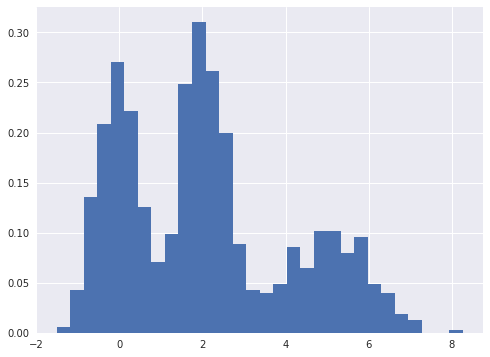

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True, lw=0);

A natural parameterization of the Gaussian mixture model is as the [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model)

$$
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(a, b) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
z\ |\ \boldsymbol{w}
    & \sim \textrm{Cat}(\boldsymbol{w}) \\
x\ |\ z
    & \sim N(\mu_z, \tau^{-1}_z).
\end{align*}
$$

An implementation of this parameterization in PyMC3 is available [here](gaussian_mixture_model.ipynb).  A drawback of this parameterization is that is posterior relies on sampling the discrete latent variable $z$.  This reliance can cause slow mixing and ineffective exploration of the tails of the distribution.

An alternative, equivalent parameterization that addresses these problems is to marginalize over $z$.  The marginalized model is

$$
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(a, b) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
f(x\ |\ \boldsymbol{w})
    & = \sum_{i = 1}^K w_i\ N(x\ |\ \mu_i, \tau^{-1}_z),
\end{align*}
$$

where

$$N(x\ |\ \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)$$

is the probability density function of the normal distribution.

Marginalizing $z$ out of the model generally leads to faster mixing and better exploration of the tails of the posterior distribution.  Marginalization over discrete parameters is a common trick in the [Stan](http://mc-stan.org/) community, since Stan does not support sampling from discrete distributions.  For further details on marginalization and several worked examples, see the [_Stan User's Guide and Reference Manual_](http://www.uvm.edu/~bbeckage/Teaching/DataAnalysis/Manuals/stan-reference-2.8.0.pdf).

PyMC3 supports marginalized Gaussian mixture models through its `NormalMixture` class.  (It also supports marginalized general mixture models through its `Mixture` class.)  Below we specify and fit a marginalized Gaussian mixture model to this data in PyMC3.

In [7]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))
    
    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)
    
    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [8]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, random_seed=SEED)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -6,663.8: 100%|██████████| 10000/10000 [00:06<00:00, 1582.50it/s]
Finished [100%]: Average ELBO = -6,582.7
100%|██████████| 5000/5000 [-1:54:12<00:00, -0.07s/it]


We see in the following plot that the posterior distribution on the weights and the component means has captured the true value quite well.

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


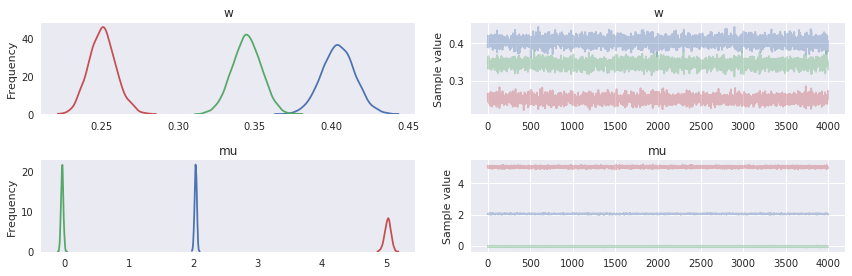

In [9]:
pm.traceplot(trace, varnames=['w', 'mu']);

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


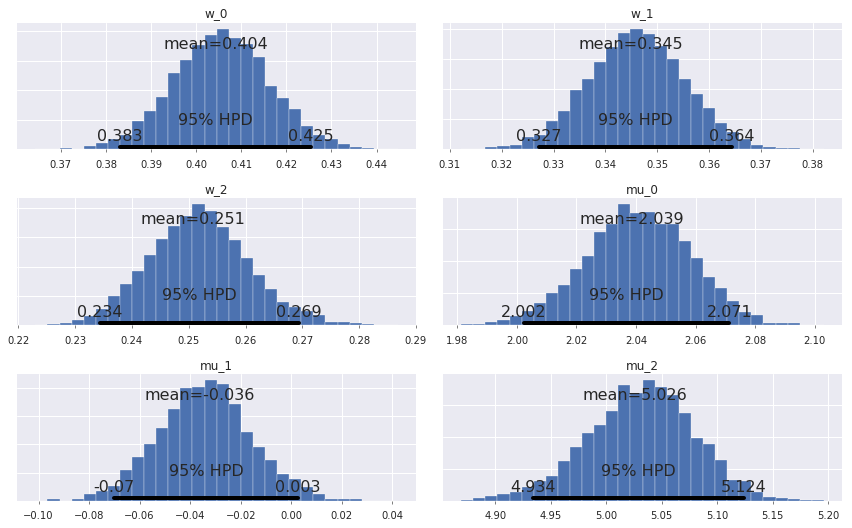

In [10]:
pm.plot_posterior(trace, varnames=['w', 'mu']);

We can also sample from the model's posterior predictive distribution, as follows.

In [11]:
with model:
    ppc_trace = pm.sample_ppc(trace, 5000, random_seed=SEED)

100%|██████████| 5000/5000 [03:28<00:00, 23.93it/s]


We see that the posterior predictive samples have a distribution quite close to that of the observed data.

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


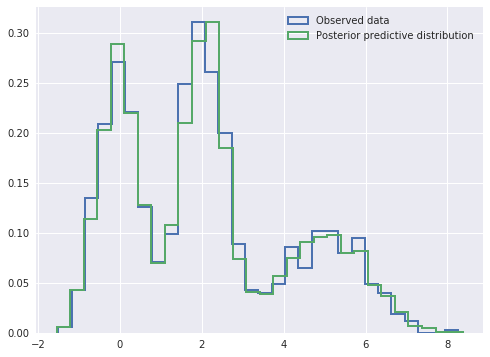

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);